# StratBuilder

This is the neatened StratBuilder code without all my of annoying essays. This code works by importing the full grids from NAYS2DH as a NumPy array and pulling out the model results for a specified location. It basically functions in 3 parts:
1. Data import
2. Plotting
3. Exports and some preliminary statistics

In [1]:
#input flags
iloc = int(input('I-location is '))#location of the section along i axis
jloc = int(input('j-location is '))#location of the secion along j axis

variabd = int(input('Enter DV flag: ')) #flag for if in variable discharge regime
adjustment_time = int(input('Enter bed adjustment time here, be wary of timestep conversion: ')) #number of timesteps, in hours taken for bed to equilibrate

I-location is  100
j-location is  0
Enter DV flag:  0
Enter bed adjustment time here, be wary of timestep conversion:  65


## Import packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import csv
import os
import scipy.stats as stats
import seaborn as sns
import math 
import matplotlib.animation as animation
import matplotlib.colors as mcol
import matplotlib.cm as cm
import time
import random
import statistics as stat
import collections
import copy 

import matplotlib.gridspec as gridspec
import warnings
warnings.filterwarnings('ignore')
from os import listdir
from os.path import isfile, join
import PIL
from xml.dom import minidom
from shapely.geometry import Polygon
#from matplotlib.animation import FuncAnimation

#from descartes import PolygonPatch
#from PIL import Image
from scipy.spatial import distance
from scipy import signal
from scipy import interpolate
from scipy.stats import variation
from mpl_toolkits.axes_grid1 import make_axes_locatable
from IPython.display import Image
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from celluloid import Camera
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)

#plt.style.use('seaborn-white')

from matplotlib.collections import LineCollection, PatchCollection
from matplotlib.colors import ListedColormap, BoundaryNorm, LinearSegmentedColormap

%matplotlib inline
#%matplotlib qt
#%matplotlib notebook
#from google.colab import drive
#drive.mount("/content/gdrive")

In /opt/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /opt/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /opt/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /opt/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /opt/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mpl

OSError: Could not find lib c or load any of its variants [].

##### Setting up all the aesthetics:
Import new colormapas, reverse them, create plot style (font, font size, etc)

In [7]:
font = {'family' : 'Helvetica',
        'weight' : 'normal',
        'size'   : 10}

mpl.rc('font', **font)
kwargs = dict(edgecolor = 'k', fc = 'xkcd:greyish', alpha=0.5, bins=20)

### Important model parameters that might be used in calculation + import data:
At the moment (March 22) the only things we need to set are:
1. cross-section location (I and J)
1. DV flag (0 for none, 1 for variable)
1. adjustment time (60 for the 2 hour strat given an average adj time of 120 hours)

Need to expand and change cell width and length if not using a 4x10 cell size!

In [8]:
Q = str(100)# discharge in m3/s
slope = 0.00137#gradient
d50 = 0.31e-3 #d50 grain size in m

thot_SS = 0 # 802800
#time from which we restarted the runs to add a flood
fldstart_s = 802800 ###start time of flood in seconds

fldlength = 0
idf = '0hfld' #identifier/classifier about the flood setting
intstring = '2hour' #time interval of output
nickname = 'agubh2-10km' #model nickname, agubh2, gentle_wide etc
floodname ='_0hrflood'

datnam = f'{idf}-datamaster-{intstring}.npy' #name of the data file to upload
dataloc = f'data-{nickname}{floodname}' #where csv files are
arrayfolder = f'c-{idf}-{nickname}' #where raw centroid data array stored
mainsurfto = f'ms-{idf}-{nickname}' #where bounding surfaces array will go
iricoutputt =600 #output time from the model, s

#print(f'/Volumes/SAF_Data/Data/ConvertedArrays/{dataloc}/{datnam}')
datamaster = np.load(f'/Volumes/SAF_Data/NAYS2DH_files/Data/ConvertedArrays/{dataloc}/{datnam}', allow_pickle = True)

### More model domain set up

cellW = 4
cellL = 10
xloc = iloc*cellL
xsloc = iloc*cellL
#print(xsloc)
spacing = 1 #spacing of cross stream x locations, m

ps = 2650 # bulk density of quartz kg/m3
p = 1000 # density of water in kg/m3
nu = 1.787*10e-6 #kinematic viscosity of water in m2/s
nu=1.0533e-6
g = 9.81 # acceleration due to gravity, m/s2

savefilesto = '/Volumes/SAF_Data/NAYS2DH_files/Plots/'
modelrun = f'{nickname}-{idf}-{iloc}'

###define grid dimensions
gridx = 1001
gridy = 26

datacond = 1
if datacond == 1:
    cells = gridy
else:
    cells = gridx
length = 1001 #length of the domain in the x direction
erostart = 5
erostop = 5

print('Shape of the datamaster dataset is: ', datamaster.shape)

num_timesteps = datamaster.shape[2] ##### or 168 for 2 weeks# len(os.listdir(filepathcore))-1 ###when u want to stop plotting
print('Number of timesteps being used: ', num_timesteps)
datamaster = datamaster[:, :, :num_timesteps]
position = np.arange(0, length, dtype = float)
coevelev = np.empty([num_timesteps])
interval_to_plot = 120/60 #we want to plot every ___  HOURS 
end_t = num_timesteps #len(np.arange(1, num_timesteps, skipstep)) #number of timesteps in data master array
fldstart = ((thot_SS+fldstart_s)/3600)/interval_to_plot ###flood starttime, s

print('Shape of data used to plot:', datamaster.shape)

Shape of the datamaster dataset is:  (26026, 11, 382)
Number of timesteps being used:  382
Shape of data used to plot: (26026, 11, 382)


Create dataframe to store data for this section

In [9]:
bardata = pd.DataFrame(columns=['BarName', 
                                'iloc', 
                                'Facies', 
                                'StartTime', 
                                'EndTime', 
                                'ElapsedTime', 
                                'LeftEdge', 
                                'RightEdge', 
                                'BarWidth', 
                                'BarHeight', 
                                'BarAspect', 
                                'BarArea', 
                                'Section Area', 
                                'ChannelProp', 
                                'MinClinoHt','MaxClinoHt', 'ModeClinoHt', 'MeanClinoHt', 'SDClinoHt', 'MedClinoHt',
                                'MinClinoWt','MaxClinoWt', 'ModeClinoWt', 'MeanClinoWt', 'SDClinoWt', 'MedClinoWt',
                                'MinClinoICD','MaxClinoICD', 'ModeClinoICD', 'MeanClinoICD', 'SDClinoICD', 'MedClinoICD',
                                'MinFlowDepth', 'MaxFlowDepth', 'ModeFlowDepth', 'MeanFlowDepth', 'SDFlowDepth', 'MedFlowDepth',
                                'MinShear', 'MaxShear', 'ModeShear', 'MeanShear', 'SDShear', 'MedShear',
                                'MinVelocity', 'MaxVelocity', 'ModeVelocity', 'MeanVelocity', 'SDVelocity', 'MedVelocity',
                                'notes'])

#### Plotting full model domain


#### Do some data wrangling

Crop and sort the data by jloc (removing ilocs that are not the desired section) so its in section order and not streamwise

In [10]:
#crop data
remove_ilocs = np.where(datamaster[:, 0, :] != iloc)
data = np.delete(datamaster, remove_ilocs[0], axis=0)
print('Cropped, final dataset shape: ', data.shape)

#sort in cross stream direction from rightbank to left bank
#test = np.empty_like(datamaster)    
for i in range (0, num_timesteps):
    data[:, :, i] = data[:, :, i][np.argsort(data[:, :, i][:, 3])]
    #print(i, data[:, 3, i])


######## Now fill in arrays for elevation, position, shear etc...

###Make the arrays to store data
stratigraphy = np.empty([end_t, cells]) ###will hold data for topography accounting for changes due to erosion
#print(elevation.shape) #elevation = np.empty([n, end_t])

# print('Shape of prelim arrays: ', stratigraphy.shape)

#this matrix is to record unmodified stratigraphy in the same shape as the eroded strat
stratigraphy_idx = stratigraphy.copy()
#stratigraphy_idx[:] =  np.nan
#print(stratigraphy)

shearstresseroded = stratigraphy.copy() #will hold data for shear stress accounting for changes due to erosion
#shearstresseroded[:] = np.nan
#print('!!!', shearstresseroded.shape)

stratflowdepth =  stratigraphy.copy() #will hold data for flow depth accounting for changes due to erosion
#stratflowdepth[:] = np.nan

scaleflowdepth =  stratigraphy.copy() #will hold data for local flow depth scaled to max accounting for changes due to erosion
#scaleflowdepth[:] = np.nan

froudedata =  stratigraphy.copy() #will hold data for local flow depth scaled to max accounting for changes due to erosion
#froudedata[:] = np.nan

velocity =  stratigraphy.copy()
runtime = len(stratigraphy)
#print(runtime)
xposition =  stratigraphy.copy()

Cropped, final dataset shape:  (26, 11, 382)


In [11]:
in_section = np.where(datamaster[:, 0, -1]==iloc)
in_section = in_section[0]
bankpos = datamaster[:, 3, :][in_section]
#print(bankpos)
rightbank = bankpos.min() ###negativee
leftbank = bankpos.max() #positive
print('Left bank max position: ', leftbank)
print('Right bank max position: ', rightbank)

xy_strat = np.empty([end_t, int(3+np.round((leftbank-rightbank)/spacing, 0))]) # will put stratigraphies here, in proper x pos
print('Shape of stratigraphy matrix:, ', xy_strat.shape)
xy_strat[:] = np.nan
ages = np.empty_like(xy_strat)

Left bank max position:  241.882453863
Right bank max position:  -230.065536143
Shape of stratigraphy matrix:,  (382, 475)


#### Import, and fill the arrays that will be used for the rest of the code
1. Import data for shear stress, flow depth, velocity and froude
2. Interpolate data to represent actual channel dimensions and not grid dimensions
3. Fill and remove any remaining nans from the arrays

In [12]:
##### Import the data
for time in range (0, data.shape[2]): #TIME
    #print(stratigraphy[time, :].shape)
    stratigraphy[time, :] = data[:, 7, time] #elevation change, elevation in 5
    shearstresseroded[time, :] = data[:, 6, time] 
    stratflowdepth[time, :] = data[:, 4, time]
    froudedata[time, :] = data[:, 9, time]
    velocity[time, :] = data[:, 10, time]
    
    ypos = data[:, 3, time]-rightbank #coreect supid centreline indexing
    #print(ypos)
    xposition[time, :] = ypos

stratigraphy_idx = stratigraphy.copy()

###you need to change the y positions from centreline position to actual positional data
#print(xposition.max(axis = 1))

##### these arrays will house interpolated data
shear = xy_strat.copy()
froude = xy_strat.copy()
scaleflow = xy_strat.copy() #flow depth scaled to max per time
trueflow = xy_strat.copy() #unscaled flow depth
flowvel = xy_strat.copy() #flow velocity

print('True shape, m: ', shear.shape, froude.shape, scaleflow.shape, trueflow.shape, flowvel.shape)

#put all data values in their correct x/index position
for t in range (0, end_t):
    #print(t)
    for idx, x in zip(np.arange(0, stratigraphy.shape[1]), xposition[t, :]):
        #print(x)
        #print(idx, x)
        x = int(np.floor(x)) #rounding down positions, making integers so can use as index
        #print(x, idx)
        xy_strat[t, x] = stratigraphy[t, idx]
        shear[t, x] = shearstresseroded[t, idx]
        froude[t, x] = froudedata[t, idx]
        trueflow[t, x] = stratflowdepth[t, idx]
        scaleflow[t, x] = scaleflowdepth[t, idx]
        flowvel[t, x] = velocity[t, idx]
    #plt.plot(xy_strat[t, :], '.')

xy_topo = np.empty_like(xy_strat)
xy_topo[:] = np.nan
for t in range (0, end_t):
    #print(t)
    length = int(np.floor(xposition[t, -1]-xposition[t, 0])) #length of the section at time, t
    pos = np.linspace(0, length, length) #create a metre scale array with each x pos = location
    #dataint = np.linspace(int(np.round(xposition[t, 0], 0)), int(np.round(xposition[t, -1], 0)), length, dtype=int) #range of locations to interpolate over?
    dataint = np.arange(xposition[t, 0], np.round(xposition[t, -1], 0), dtype=int)
    #print(t, pos.max(), length)
    #print(len(dataint))
    #print(pos)
    
    stratnotnan = xy_strat[t, :][~np.isnan(xy_strat[t, :])] #pull out real values of strat
    shearnotnan = shear[t, :][~np.isnan(shear[t, :])] #pull out real values of shear
    froudenotnan = froude[t, :][~np.isnan(froude[t, :])] #pull out real values of froude
    truefnotnan = trueflow[t, :][~np.isnan(trueflow[t, :])] #pull out real values of true flow depth
    #scalefnotnan = scaleflow[t, :][~np.isnan(scaleflow[t, :])] #pull out real values of scaled flow depth
    velnotnan = flowvel[t, :][~np.isnan(flowvel[t, :])] #pull out real values of strat
    #print(shear[t, :][~np.isnan(shear[t, :])])
    #print(shearnotnan[:].shape, froudenotnan[:].shape, truefnotnan[:].shape, velnotnan[:].shape)
    #print(xposition[t, :])
    #print(dataint)
    fx = interpolate.interp1d(xposition[t, :], stratnotnan[:], kind = 'cubic', fill_value = 'extrapolate') #stratigraphy interpolation
    #print(fx)
    fsh = interpolate.interp1d(xposition[t, :], shearnotnan[:], kind = 'cubic', fill_value = 'extrapolate') #shear stress interpolation
    ffr = interpolate.interp1d(xposition[t, :], froudenotnan[:], kind = 'cubic', fill_value = 'extrapolate') #froude number interpolation
    ftf = interpolate.interp1d(xposition[t, :], truefnotnan[:], kind = 'cubic', fill_value = 'extrapolate') #true flow depth interpolation
    #fsf = interpolate.interp1d(xposition[t, :], scalefnotnan[:], kind = 'cubic') #scaled flow depth interpolation
    ffv = interpolate.interp1d(xposition[t, :], velnotnan[:], kind = 'cubic', fill_value = 'extrapolate') #flow veloity interpolation
    
    #print(fx(dataint))
    
    xy_topo[t, dataint] = fx(dataint) #reassign strat
    #print(xy_topo[t, :])
    shear[t, dataint] = fsh(dataint) #reassign shear
    froude[t, dataint] = ffr(dataint) #reassign froude
    trueflow[t, dataint] = ftf(dataint) #reassign true fd
    #scaleflow[t, 0:length] = fsf(pos) #reassign scaled fd
    flowvel[t, dataint] = ffv(dataint) #reassign flow vel
    
    #plt.plot(xy_topo[t, :])
#plt.ylim(-3, 3)

True shape, m:  (382, 475) (382, 475) (382, 475) (382, 475) (382, 475)


NameError: name 'interpolate' is not defined

In [9]:
## Find area of cross section
fig = plt.figure()
xs_area = plt.fill_between(np.arange(0, xy_topo.shape[1]), xy_topo[0], xy_topo[-1])
plt.close(fig)
xs_verts = xs_area.get_paths()[0].vertices
xs_polygon = Polygon(xs_verts) 

xs_bds = xs_polygon.bounds
xs_area = xs_polygon.area
xsleft = xs_bds[0]
xsbottom = xs_bds[1]
xsright = xs_bds[2]
xstop = xs_bds[3]
#bar_height = abs(bottom-top)
xs_thick = abs(xy_topo[-1].min()-xy_topo[-1].max())
xs_width = xsright-xsleft

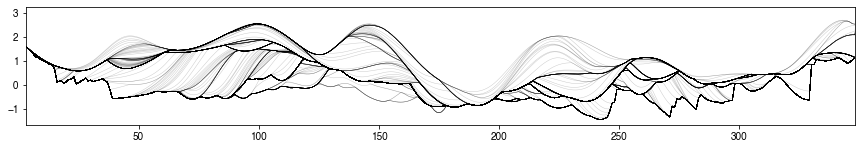

In [10]:
#each of these conditional arrays have a border of nans to helo pick out the 'packages'
stratcondition = np.zeros_like(xy_topo)
stratcondition[:] = np.nan


erosurf = np.empty([end_t, xy_topo.shape[1]])
erosurf[:] = np.nan

strat = copy.deepcopy(xy_topo)

halfwidth=25

for time in range (0, end_t):
    
    #now we have stratigraphy at each timestep with time on the j axis and position on the i
    #we want to check each location at each timestep for areas that have erodible elevation (i.e. higher than current timestep)
    
    for space in range (0, xy_topo.shape[1]):
        #print(space)
        preexisting_strata = xy_topo[:time, :] #this is our search array, where we will erode
        #preexisting_strata_idx = stratigraphy_idx[:time, :]
        
        #print(preexisting_strata.shape)
        #print('xy', xy_strat[time, :].shape)
        willerode = np.where(preexisting_strata[:, space] > xy_topo[time, space])
        #print('willerode', willerode)
        
        #print(time, column, willerode)
        
        xy_topo[willerode, space] = xy_topo[time, space]
        ages[willerode, space] = time


for i in range (end_t-2, -1, -1):
    
    fillinx = np.where(np.isnan(xy_topo[i, :]))
    xy_topo[i, fillinx] = xy_topo[i+1, fillinx]
    #strat[i, fillinx] = strat[i+1, fillinx]
    ##### fill in all filled in areas in the strat condition matrix with the flag for erosion
    stratcondition[i, fillinx] = 1
    #print(stratcondition[i, fillinx])
    
    fillinsh = np.where(np.isnan(shear[i, :]))
    shear[i, fillinsh] = shear[i+1, fillinsh]
    
    fillinfr = np.where(np.isnan(froude[i, :]))
    froude[i, fillinfr] = froude[i+1, fillinfr]
    
    fillintf = np.where(np.isnan(trueflow[i, :]))
    trueflow[i, fillintf] = trueflow[i+1, fillintf]
    
    fillinsf = np.where(np.isnan(scaleflow[i, :]))
    scaleflow[i, fillinsf] = scaleflow[i+1, fillinsf]
    
    fillinfv = np.where(np.isnan(flowvel[i, :]))
    flowvel[i, fillinfv] = flowvel[i+1, fillinfv]
    
    fillinstrat = np.where(np.isnan(strat[i, :]))
    #strat[i, fillinstrat] = strat[i+1, fillinstrat]
    
    #print('no fill', xy_topo[i, fillin])
    
    #print('fill', xy_topo[i, fillin])

###### *Verify that the stratigraphy looks the way it should*

#%matplotlib notebook
fig, ax = plt.subplots(figsize = (12, 3), tight_layout=True)
for i in range(0, end_t):
    ax.plot(xy_topo[i, :], 'k', alpha = 0.2, lw = 0.5)
ax.set_aspect('10')
ax.set_xlim(xposition[-1, :].min(), xposition[-1, :].max());
#ax.axvline(abs(data[:, 3, -1]).min()-rightbank, c='b', ls='-.', lw=1)
#plt.savefig(f'{savefilesto}showfig-{iloc}.png', dpi = 200)

##### Declare maximum flow depth for scaling

In [11]:
maxflow = np.reshape(np.nanmax(trueflow, axis=1), [end_t, 1]) ## max flow across the section at each timestep
scaleflow = trueflow/maxflow

#### Set up the grids for plotting and facies modelling

In [12]:
start_time = 0 #would be start of model run
end_time = end_t #would be end of model run

tim = range(start_time,end_time) #range of time

position = np.arange(0, xy_topo.shape[1], dtype = float)

## mobility parameter from van den berg and van gelder 1993
temp = 20.0 #temperature in degrees celcius
kv = (1.14-0.031*(temp-15)+0.00068*((temp-15)**2))*10**-6
print(kv)
D_star = np.power((1.65*9.81)/(1e3*(kv**2)), 0.333)*3.1e-4
print(D_star)
d50um = 310
chezy_rough = 18*(np.log10(4*trueflow/d50)) #i think this is log10, else they would've put ln no?

mmp =(p*(flowvel**2))/(1650*(chezy_rough**2)*d50)##### modified mobility parameter
mmprange = [0.01, 0.025, 0.17, 0.35, 1.5, 10] ##### LP, R, D, D-UP, UP

# Set up plotting cmaps

# Make a user-defined colormap.
cm1 = 'hsv'
cnorm = mcol.Normalize(vmin=min(tim),vmax=max(tim))

# Turn these into an object that can be used to map time values to colors and can be passed to plt.colorbar().
cpick = cm.ScalarMappable(norm=cnorm,cmap='hsv') 
cpick.set_array([])

cmap_vvfac = ListedColormap(['xkcd:mud brown', 'xkcd:shit', 'xkcd:dark tan', 'xkcd:sand', 'xkcd:stone'])
#mmprange = [0.01, 0.025, 0.17, 0.35, 1.5, 10] ##### LP, R, D, D-UP, UP
norm_vvfac = BoundaryNorm(mmprange, cmap_vvfac.N)

1.0019999999999997e-06
0.7770191533135022


/var/folders/yg/89nlrh5x2xzgdlgr2bczm4_m0000gn/T/ipykernel_22010/1280023303.py:15: RuntimeWarning: invalid value encountered in log10
  chezy_rough = 18*(np.log10(4*trueflow/d50)) #i think this is log10, else they would've put ln no?


#### Create erosional, depositional and hiatal surfaces

In [13]:
ages_ero = np.empty_like(xy_topo)
posnew = np.arange(0, xy_topo.shape[1])

##### SCENARIO 1: Hiatus = any elevation change that is less than x cm

##### SCENARIO 2: Hiatus = any elevation change that is less than x % of the average elevation change

##### SCENARIO 3: Hiatus = any elevation change that is less than the xth percentile of change at the timestep
hiatal_scenario = 2

threshold_thick = 0.005  #absolute value in metres 

nth = 25 #what percentile distribution to use to calculate hiatal surfaces for each timestep
perc = 0.1 #fraction of percentile

###### Now we are defining the ages of each surface 

#print(len(posnew))
for time in range (1, end_t):
    #print(time)
    ages_ero[time, :] = time 
    #stratinterpcub[time, :] = topointerp[time, :]
    
    lessthan = np.where(strat[time, :] < xy_topo[time-1, :]) ###where it erodes
    #print(lessthan)
    ele_change = strat[time, :]-xy_topo[time-1, :] #find the bed elevation change across the domain
                                                                   #it has to be before you reassign topography else 
                                                                   #you will get zeros where replaced
   
    ages_ero[time, lessthan] = ages_ero[time-1, lessthan]
        
    
    if hiatal_scenario == 1:
        threshold_thick = perc*(np.nanmean(ele_change)) #find the fraction of the average elevation change between the two latest timesteps
    
    if hiatal_scenario == 2:
        threshold_thick = perc*np.nanpercentile(ele_change, nth)
    
    if time != 0:
        hiatus_idx = np.where(abs(ele_change) < abs(threshold_thick))
       # print(time, hiatus_idx, threshold_thick)
  
        ages_ero[time, hiatus_idx] = ages_ero[time-1, hiatus_idx]
        #print(ages_ero[time, :])
ages_ero[-1, :] = end_t
#        print(ages_ero)

#### Making the arrays that store erosion, hiatal, deposition and erosional and hiatal surfaces

#these will all be filled with nans
deposurf = erosurf.copy()
hiatalsurf = erosurf.copy()
erohiatalsurf = erosurf.copy()
time_of_ero = erosurf.copy()

###### Create stratcondition (0, 1, 2 for depo, ero, hiatal) and surface arrays with nans and topo of ero/depo/hiatal surfaces


thickness = np.zeros_like(xy_topo)


fig, ax = plt.subplots(2, 3, figsize = (19.80, 10.8), tight_layout = True)#, sharey = True, sharex = True)#, sharex = True, sharey = True)

for time in range (1, end_t):
    
    
    #ax[0,0].plot(posnew, topointerp[time], color=cpick.to_rgba(time))
    thickness[time, :] = strat[time, :]-strat[time-1, :]
    thickness[time, :][np.isnan(thickness[time, :])] = 0
    
    if hiatal_scenario == 1:
            #using a percentage of the average thickness to constrain hiatal surfaces
        threshold_thick = perc*(np.mean(thickness[time, :]))  #x% of the average sediment thickness at x time. may be negative.
    elif hiatal_scenario == 2:
            #using nth percentile of the thicknesses at each timestep
        threshold_thick = perc*np.percentile(abs(thickness[time, :]), nth) #find the nth percentile of depositon at x time. positive number.
    
    ax[0,0].plot(time, threshold_thick, 'o', markerfacecolor = cpick.to_rgba(time), markeredgecolor = cpick.to_rgba(time), linewidth = 0.0001, markersize = 14, alpha = 0.5)
    
    
    ax[0,0].set_ylim(-0.05, .05)
    #print('10th', np.percentile(abs(thickness), nth), 'thresh', threshold_thick)
    
    hiatalwhere = np.where(abs(thickness[time, :]) < threshold_thick) #where elev change is less than 10% avg
    depositingwhere = np.where(thickness[time, :] > threshold_thick)
    erodingwhere = np.where(thickness[time, :] < -abs(threshold_thick))

    stratcondition[time, depositingwhere] = 0
    stratcondition[time, erodingwhere] = 1
    stratcondition[time, hiatalwhere] = 2
    erodereset = np.where(stratcondition[time, :]==1)
   
 
    erosurf[time, erodereset] = xy_topo[time, erodereset]
    deposurf[time, depositingwhere] = xy_topo[time, depositingwhere]
    hiatalsurf[time, hiatalwhere] = xy_topo[time, hiatalwhere]
    erohiatalsurf[time, erodereset] = xy_topo[time, erodereset]
    erohiatalsurf[time, hiatalwhere] = xy_topo[time, hiatalwhere]
    #print('surf', erosurf[time, 220:])
    
    # ax[1,0].plot(erosurf[time], color=cpick.to_rgba(time))
    # ax[1,1].plot(hiatalsurf[time], color=cpick.to_rgba(time))
    # ax[0, 2].plot(deposurf[time], color=cpick.to_rgba(time))
    # #ax[1, 2].plot(posnew, erohiatalsurf[time], color=cpick.to_rgba(time))
    # ax[1, 2].plot(erosurf[time], 'r')
    # ax[1, 2].plot(hiatalsurf[time], 'g')

plt.close(fig)

## Da Biznizzzz (cropping the bars)

In [57]:
goflag = 'y'

labelbars = plt.figure(figsize = (20, 5), tight_layout = True, dpi = 200)
fnlfig = plt.gca()

while goflag=='y':
    #import matplotlib
    mpl.use('TkAgg')
    #%matplotlib tk

    fig = plt.figure(tight_layout=True, figsize = (20, 8))
    ax = plt.gca()

    ax.set_aspect('20')
    ax.set_facecolor('k')

    for i in range (0, end_t):
        plt.plot(erohiatalsurf[i], color = cpick.to_rgba(i), lw = 1)
    ticks = np.arange(0, end_t, 25)
    ax.xaxis.set_minor_locator(MultipleLocator(10))
    # ax.colorbar(cpick,label="Time", shrink=0.3, ticks=ticks, aspect = 20, pad = 0.1, orientation = 'horizontal')

    start_time = 0 #would be start of model run
    end_time_int = num_timesteps-1 #would be end of model run

    tim_int = range(start_time,end_time) #range of time
    xdat_int = posnew #position
    ydat_int = [xy_topo[t] for t in tim_int] #stratigraphy/elevation @ position

    for strata in range (0, end_t):

        elevint = xy_topo[strata]
        vvfacies = mmp[strata] #van den berg and van gelder

        pointsint = np.array([posnew, elevint]).T.reshape(-1, 1, 2)
        segmentsint = np.concatenate([pointsint[:-1], pointsint[1:]], axis=1)

        #-------- MOBILITY WITH MMP
        vvfac = LineCollection(segmentsint, cmap = cmap_vvfac, norm = norm_vvfac)
        vvfac.set_array(vvfacies)
        vvfac.set_linewidth(1.5)
        vvfac_line = ax.add_collection(vvfac)

    hmm = np.array(plt.ginput(4)) #extract 4 coordinates from the plot
    # plt.close(fig)

    %matplotlib inline
    fakecrop = copy.deepcopy(xy_topo[:, int(hmm[0, 0]):int(hmm[1, 0])])
    # for i in range (0, num_timesteps):
        # plt.plot(fakecrop[i, :])

    if hmm.shape != (4, 2):
        print('check coordinates!!')
        break

    # st_time = np.where(np.logical_and(np.isclose(xy_topo, hmm[2, 1], atol=0.005), (np.isclose(strat, hmm[2, 1], atol=0.005))))[0][0] ##get the row index of the start time picked from the plot
    searchst = np.arange(int(hmm[2, 0])-5, int(hmm[2, 0])+5)
    searchen = np.arange(int(hmm[3, 0])-5, int(hmm[3, 0])+5)
    st_time = np.where(np.isclose(erohiatalsurf[:, searchst], hmm[2, 1], atol=0.05))[0][-1]
    en_time = np.where(np.isclose(erohiatalsurf[:, searchen], hmm[3, 1], atol=0.05))[0][0]
    bar_time = en_time-st_time
    #en_time = np.where(np.logical_and(np.isclose(xy_topo, hmm[3, 1], atol=0.001), (np.isclose(strat, hmm[3, 1], atol=0.001))))[0][0] ##get the row index of the start time picked from the plot
    #print(st_time)
    print(st_time, en_time) #start and end times of bar deposition

    barleft = int(hmm[0, 0])
    barright = int(hmm[1, 0])

    fakecrop = fakecrop[st_time:en_time, :]
    # for i in range (0, len(fakecrop)):
        # plt.plot(fakecrop[i, :])

    pkg_type = input('Enter bar facies type: ')
    bargrade = input('Enter bar grade: ')
    barID = f'{iloc}-{bargrade}-{pkg_type}'
    cropped_topo = copy.deepcopy(xy_topo[st_time:en_time+1, barleft:barright+1])

    #lt.colorbar(cpick,label="Time")

    ####Pull flow depth data

    maxdep = np.nanmax(trueflow[st_time:en_time+1, :])
    depCV = stats.variation(trueflow[st_time:en_time+1, :][~np.isnan(trueflow[st_time:en_time+1, :])].ravel())


    ## Crop EVERYTHING

    ## crop the strat matrix too
    xy_topoc = copy.deepcopy(cropped_topo)
    positionc = position[barleft:barright+1]
    stratc = xy_strat[st_time:en_time+1, barleft:barright+1]
    #stratconditionc = stratcondition[st_time:en_time+1, barleft:barright+1]

    end_tc = len(xy_topoc)
    num_timestepsc = end_tc

    shearc = shear[st_time:en_time+1, barleft:barright+1]
    scaleflowc = scaleflow[st_time:en_time+1, barleft:barright+1]
    trueflowc = trueflow[st_time:en_time+1, barleft:barright+1]
    flowvelc = flowvel[st_time:en_time+1, barleft:barright+1]
    ehsurfc = erohiatalsurf[st_time:en_time+1, barleft:barright+1]

    #=============MAKE MASTER ARRAY FOR BAR PKG, EXPORT============================
    if not os.path.exists(f'/Volumes/SAF_Data/NAYS2DH_files/Data/nparrays/barpkg-arrays-fall23-patch/{iloc}'):
        os.makedirs(f'/Volumes/SAF_Data/NAYS2DH_files/Data/nparrays/barpkg-arrays-fall23-patch/{iloc}')

    masterarr = np.concatenate((np.expand_dims(xy_topoc, 2), 
                                np.expand_dims(ehsurfc, 2), 
                                np.expand_dims(shearc, 2),
                                np.expand_dims(trueflowc, 2),
                                np.expand_dims(flowvelc, 2)), axis=2)
    np.save(f'/Volumes/SAF_Data/NAYS2DH_files/Data/nparrays/barpkg-arrays-fall23-patch/{iloc}/{barID}', masterarr, allow_pickle=True)

    ####————————————————— EXTRACT FLOW DEPTH STATISTICS—————————————————————————————
    max_depth= np.nanmax(trueflowc)
    min_depth = np.nanmin(trueflowc)
    mean_depth = np.nanmean(trueflowc)
    stddev_depth = np.nanstd(trueflowc)
    mod_depth = float(stats.mode(trueflowc, nan_policy = 'omit')[0][0][0])
    med_depth = np.nanmedian(trueflowc)

    ####————————————————— EXTRACT SHEAR STRESS STATISTICS—————————————————————————————
    max_shear= np.nanmax(shearc)
    min_shear = np.nanmin(shearc)
    mean_shear = np.nanmean(shearc)
    stddev_shear = np.nanstd(shearc)
    mod_shear = float(stats.mode(shearc, nan_policy = 'omit')[0][0][0])
    med_shear = np.nanmedian(shearc)

    ####————————————————— EXTRACT FLOW VELOCITY STATISTICS—————————————————————————————
    max_vel= np.nanmax(flowvelc)
    min_vel = np.nanmin(flowvelc)
    mean_vel = np.nanmean(flowvelc)
    stddev_vel = np.nanstd(flowvelc)
    mod_vel = float(stats.mode(flowvelc, nan_policy = 'omit')[0][0][0])
    med_vel = np.nanmedian(flowvelc)

    ##————————————––––––––––––––––––––––––––––––GET BAR PACKAGE DIMENSIONS————————————––––––––––––––––––––––––
    fig=plt.figure()
    fullbar = plt.fill_between(posnew[barleft:barright+1], xy_topoc[0], xy_topoc[-1])
    plt.close(fig)

    barverts = fullbar.get_paths()[0].vertices
    bar_polygon = Polygon(barverts) 
    bds = bar_polygon.bounds
    bar_area = bar_polygon.area
    left = bds[0]
    bottom = bds[1]
    right = bds[2]
    top = bds[3]
    bar_height = abs(np.nanmin(xy_topoc[-1])-np.nanmax(xy_topoc[-1]))
    bar_width = right-left
    bar_w_to_h = bar_width/bar_height
    prop_area = bar_area/xs_area

    ###==================================GET CENTROIDS AND INTERNAL STATS==================================

    nan_border = np.empty([end_tc, 1])
    nan_border.shape
    nan_border[:] = np.nan
    #topointerp_nb = np.concatenate((nan_border, strat, nan_border), axis = 1) #nb = nan border
    stratinterpcub_nb = np.concatenate((nan_border, xy_topoc, nan_border), axis = 1)

    posnewc = np.arange(0, xy_topoc.shape[1], dtype = float)
    posnewc_nb = np.insert(posnewc, [0], [np.nan])
    posnewc_nb = np.insert(posnewc_nb, -1, np.nan)

    SIC_startcrop = copy.deepcopy(xy_topoc)
    SIC_startcrop = np.concatenate((nan_border, SIC_startcrop, nan_border), axis = 1)

    SIC_startcrop = np.delete(SIC_startcrop, 0, axis = 0)
    SIC_startcrop.shape

    SIC_endcrop = copy.deepcopy(xy_topoc)
    SIC_endcrop = np.concatenate((nan_border, SIC_endcrop, nan_border), axis = 1)

    SIC_endcrop = np.delete(SIC_endcrop, -1, axis=0)
    SIC_endcrop.shape

    delta = SIC_startcrop-SIC_endcrop

    delta[np.where(delta[:]==0)] = np.nan

    #print(len(posnewc_nb))
    #l_edges = np.empty([1,]) #left edge distance measure of the wheeler fill
    l_idx = np.empty([1,]) #index value of left edge
    #r_edges = np.empty([1,]) #right edge of the wheeler fill
    r_idx = np.empty([1,]) #index value of right edge
    surf_age = np.empty([1,]) #age of each deposit for the wheeler diagram
    for i in range (0, len(delta)):
        #if ~np.isnan(deposurf[i, 0]):
        #   rectangles[i, 0] = ages[i, 0] #if the left edge of the stratigraphy is a depositional surface

        for xpos in range (0, len(posnewc_nb)-1):
            l_edge = np.all((np.isnan(delta[i, xpos]) and ~np.isnan(delta[i, xpos+1])))
            r_edge = np.all((~np.isnan(delta[i, xpos]) and np.isnan(delta[i, xpos+1])))
            #print(xpos, 'L', l_edge)
            #print(xpos, 'R', r_edge)
            if l_edge == True:
                #l_edges = np.append(l_edges, [posnewc_nb[xpos+1]], axis = 0)
                l_idx = np.append(l_idx, [xpos], axis = 0)
                #print(posnewc_nb[xpos+1], 'potato')
                surf_age = np.append(surf_age, [i], axis = 0)
            if r_edge == True:
                #print(xpos, 'tomato')
                #r_edges = np.append(r_edges, [posnewc_nb[xpos-1]], axis = 0)
                r_idx = np.append(r_idx, [xpos], axis = 0)


    # Store all those vertices in an array that houses the time of each polygon and the left and right edges of the poly

    l_idx = np.reshape(l_idx, [len(l_idx), 1])
    #l_index = np.delete(l_index, 1)

    l_idx = l_idx.astype(int)
    r_idx = np.reshape(r_idx, [len(r_idx), 1])
    #r_index = np.delete(r_index, 1)
    r_idx = r_idx.astype(int)

    #print(l_idx[:, 0], r_idx[:, 0])
    surf_age = np.reshape(surf_age, [len(surf_age), 1])

    # print(l_idx.shape, r_idx.shape, surf_age.shape)

    vertices_b = surf_age
    vertices_b = np.append(vertices_b, l_idx, axis = 1)
    vertices_b = np.append(vertices_b, r_idx, axis = 1)

    #print(vertices)#, vertices.shape)


    cent_array = np.empty([len(vertices_b), 8])
    cent_array[:] = np.nan
    cent_mass = np.empty([len(vertices_b), 2]) ##store the centre of mass of the polygons
    # print(cent_mass.shape)

    ## Plot the filled stratigraphy, create a polygon for each, find the centroid, store the centroid and its age
    testfig, ax1 = plt.subplots(1, 1, tight_layout=True, squeeze=True, figsize = (10,6))
    poly_data = {}
    for i in range (1, len(vertices_b)):
        time = int(vertices_b[i, 0])
        left = int(vertices_b[i, 1])
        right = int(vertices_b[i, 2])

        poly = ax1.fill_between(posnewc[left:right], xy_topoc[time, left:right], xy_topoc[time+1, left:right], color=cpick.to_rgba(i))
        pverts = poly.get_paths()[0].vertices

        polygon = Polygon(pverts) #create a shapely polygon
        #print(polygon)
        poly_data[i] = polygon
        area = polygon.area
        bounds = polygon.bounds
        #print(type(bounds[0]))
        cent_array[i, 4] = bounds[0]
        cent_array[i, 5] = bounds[1]
        cent_array[i, 6] = bounds[2]
        cent_array[i, 7] = bounds[3]
        cent_array[i, 3] = area
        ctroid = polygon.centroid
        cent_array[i, 0] = time
        cent_array[i, 1] = ctroid.x
        cent_array[i, 2] = ctroid.y

    ptile10 = 1 ## setting an actual threshold bc some of these are still too small


    cent_wnan = copy.deepcopy(cent_array)
    deletewhere = np.where(cent_array[:, 3] < ptile10)
    cent_wnan[deletewhere] = np.nan

    cent_nonan = cent_wnan[~np.isnan(cent_wnan).any(axis = 1)] #delete all rows in cent_wnan matrix with nan values

    poly_widths = cent_nonan[:, 6]-cent_nonan[:, 4]
    poly_widths = np.reshape(poly_widths, [len(poly_widths), 1])

    poly_heights = cent_nonan[:, 7]-cent_nonan[:, 5]
    poly_heights = np.reshape(poly_heights, [len(poly_heights), 1])

    cent_nonan = np.concatenate((cent_nonan, poly_widths, poly_heights), axis = 1)

    range_x = position.max()-position.min()
    range_y = np.nanmax(xy_topoc)-np.nanmin(xy_topoc)
    # print(range_x, range_y)

    dists = np.zeros([len(cent_nonan[:, 3]), 1])
    reltime = np.zeros([len(cent_nonan[:, 3]), 1]) #will store the elapsed time between two consecutive centroids
    delx = np.zeros([len(cent_nonan[:, 3]), 1])
    dely = np.zeros([len(cent_nonan[:, 3]), 1])

    for i in range (0, len(cent_nonan)-1):
        dists[i, 0] = ((cent_nonan[i+1, 1]-cent_nonan[i, 1])**2+(cent_nonan[i+1, 2]-cent_nonan[i, 2])**2)**0.5
        reltime[i,0] = cent_nonan[i+1, 0]-cent_nonan[i, 0]
        delx[i, 0] = abs(cent_nonan[i+1, 1]-cent_nonan[i, 1])/range_x
        dely[i, 0] = abs(cent_nonan[i+1, 2]-cent_nonan[i, 2])/range_y
    cent_nonan = np.concatenate((cent_nonan, dists, reltime, delx, dely), axis = 1)


    delx = np.delete(delx, -1, axis=0)
    dely = np.delete(dely, -1, axis=0)


    ####————————————————— EXTRACT CLINO STATISTICS—————————————————————————————
    mod_ht =float(stats.mode(poly_heights)[0])
    med_ht = np.median(poly_heights)
    mean_ht = np.mean(poly_heights)
    max_ht = np.max(poly_heights)
    min_ht = np.min(poly_heights)
    stddev_ht = np.std(poly_heights)

    ## Widths
    mod_wt = float(stats.mode(poly_widths)[0])
    med_wt = np.median(poly_widths)
    mean_wt = np.mean(poly_widths)
    max_wt = np.max(poly_widths)
    min_wt = np.min(poly_widths)
    stddev_wt = np.std(poly_widths)

    ## ICDs
    mod_icd =float(stats.mode(dists)[0])
    med_icd = np.median(dists)
    mean_icd = np.mean(dists)
    max_icd = np.max(dists)
    min_icd = np.min(dists)
    stddev_icd = np.std(dists)

    ###--------------------Relating clinos to full bar--------------------------------

    packages_rel_to_bar_height = cent_nonan[:, 9]/bar_height
    prop_of_xs_is_bar = bar_area/xs_polygon.area 

    note = input('any notes? ')
    plt.close()

    pkgdata = pd.DataFrame([(barID, iloc, pkg_type, st_time, en_time, bar_time, barleft, barright, bar_width, bar_height, bar_w_to_h, bar_area, xs_area, prop_area,
                            min_ht, max_ht, mod_ht, mean_ht, stddev_ht, med_ht,
                            min_wt, max_wt, mod_wt, mean_wt, stddev_wt, med_wt,
                            min_icd, max_icd, mod_icd, mean_icd, stddev_icd, med_icd,
                            min_depth, max_depth, mod_depth, mean_depth, stddev_depth, med_depth, 
                            min_shear, max_shear, mod_shear, mean_shear, stddev_shear, med_shear, 
                            min_vel, max_vel, mod_vel, mean_vel, stddev_vel, med_vel, note)],

                           columns=['BarName', 
                                'iloc', 
                                'Facies', 
                                'StartTime', 
                                'EndTime', 
                                'ElapsedTime', 
                                'LeftEdge', 
                                'RightEdge', 
                                'BarWidth', 
                                'BarHeight', 
                                'BarAspect', 
                                'BarArea', 
                                'Section Area', 
                                'ChannelProp', 
                                'MinClinoHt','MaxClinoHt', 'ModeClinoHt', 'MeanClinoHt', 'SDClinoHt', 'MedClinoHt',
                                'MinClinoWt','MaxClinoWt', 'ModeClinoWt', 'MeanClinoWt', 'SDClinoWt', 'MedClinoWt',
                                'MinClinoICD','MaxClinoICD', 'ModeClinoICD', 'MeanClinoICD', 'SDClinoICD', 'MedClinoICD',
                                'MinFlowDepth', 'MaxFlowDepth', 'ModeFlowDepth', 'MeanFlowDepth', 'SDFlowDepth', 'MedFlowDepth',
                                'MinShear', 'MaxShear', 'ModeShear', 'MeanShear', 'SDShear', 'MedShear',
                                'MinVelocity', 'MaxVelocity', 'ModeVelocity', 'MeanVelocity', 'SDVelocity', 'MedVelocity',
                                'notes'])
    bardata = pd.concat([bardata, pkgdata], axis = 0, ignore_index = True)
    ## final bar plot
    
    goflag = input('Go flag: ')
    
    x, y = bar_polygon.exterior.xy
    fnlfig.plot(x, y, label = barID)
#fnlfig.legend()
    
bardata.to_csv(f'/Volumes/SAF_Data/NAYS2DH_files/Data/barCSVs/Fall23_patch/{barID}.csv')

Exception in Tkinter callback
Traceback (most recent call last):
  File "/Applications/anaconda3/lib/python3.8/tkinter/__init__.py", line 1892, in __call__
    return self.func(*args)
  File "/Applications/anaconda3/lib/python3.8/tkinter/__init__.py", line 814, in callit
    func(*args)
  File "/Applications/anaconda3/lib/python3.8/site-packages/matplotlib/backends/_backend_tk.py", line 476, in delayed_destroy
    self.window.destroy()
  File "/Applications/anaconda3/lib/python3.8/tkinter/__init__.py", line 2311, in destroy
    for c in list(self.children.values()): c.destroy()
  File "/Applications/anaconda3/lib/python3.8/tkinter/__init__.py", line 2583, in destroy
    Misc.destroy(self)
  File "/Applications/anaconda3/lib/python3.8/tkinter/__init__.py", line 640, in destroy
    self.tk.deletecommand(name)
_tkinter.TclError: can't delete Tcl command


165 242


Enter bar facies type:  la
Enter bar grade:  a
any notes?  nice
Go flag:  y


Exception in Tkinter callback
Traceback (most recent call last):
  File "/Applications/anaconda3/lib/python3.8/tkinter/__init__.py", line 1892, in __call__
    return self.func(*args)
  File "/Applications/anaconda3/lib/python3.8/tkinter/__init__.py", line 814, in callit
    func(*args)
  File "/Applications/anaconda3/lib/python3.8/site-packages/matplotlib/backends/_backend_tk.py", line 476, in delayed_destroy
    self.window.destroy()
  File "/Applications/anaconda3/lib/python3.8/tkinter/__init__.py", line 2311, in destroy
    for c in list(self.children.values()): c.destroy()
  File "/Applications/anaconda3/lib/python3.8/tkinter/__init__.py", line 2583, in destroy
    Misc.destroy(self)
  File "/Applications/anaconda3/lib/python3.8/tkinter/__init__.py", line 640, in destroy
    self.tk.deletecommand(name)
_tkinter.TclError: can't delete Tcl command


320 375


Enter bar facies type:  la
Enter bar grade:  a
any notes?  agg
Go flag:  y


Exception in Tkinter callback
Traceback (most recent call last):
  File "/Applications/anaconda3/lib/python3.8/tkinter/__init__.py", line 1892, in __call__
    return self.func(*args)
  File "/Applications/anaconda3/lib/python3.8/tkinter/__init__.py", line 814, in callit
    func(*args)
  File "/Applications/anaconda3/lib/python3.8/site-packages/matplotlib/backends/_backend_tk.py", line 476, in delayed_destroy
    self.window.destroy()
  File "/Applications/anaconda3/lib/python3.8/tkinter/__init__.py", line 2311, in destroy
    for c in list(self.children.values()): c.destroy()
  File "/Applications/anaconda3/lib/python3.8/tkinter/__init__.py", line 2583, in destroy
    Misc.destroy(self)
  File "/Applications/anaconda3/lib/python3.8/tkinter/__init__.py", line 640, in destroy
    self.tk.deletecommand(name)
_tkinter.TclError: can't delete Tcl command


329 349


Enter bar facies type:  la
Enter bar grade:  b
any notes?  agg but not nice
Go flag:  y


Exception in Tkinter callback
Traceback (most recent call last):
  File "/Applications/anaconda3/lib/python3.8/tkinter/__init__.py", line 1892, in __call__
    return self.func(*args)
  File "/Applications/anaconda3/lib/python3.8/tkinter/__init__.py", line 814, in callit
    func(*args)
  File "/Applications/anaconda3/lib/python3.8/site-packages/matplotlib/backends/_backend_tk.py", line 476, in delayed_destroy
    self.window.destroy()
  File "/Applications/anaconda3/lib/python3.8/tkinter/__init__.py", line 2311, in destroy
    for c in list(self.children.values()): c.destroy()
  File "/Applications/anaconda3/lib/python3.8/tkinter/__init__.py", line 2583, in destroy
    Misc.destroy(self)
  File "/Applications/anaconda3/lib/python3.8/tkinter/__init__.py", line 640, in destroy
    self.tk.deletecommand(name)
_tkinter.TclError: can't delete Tcl command


263 310


Enter bar facies type:  la
Enter bar grade:  a
any notes?  agg fine rich
Go flag:  y


Exception in Tkinter callback
Traceback (most recent call last):
  File "/Applications/anaconda3/lib/python3.8/tkinter/__init__.py", line 1892, in __call__
    return self.func(*args)
  File "/Applications/anaconda3/lib/python3.8/tkinter/__init__.py", line 814, in callit
    func(*args)
  File "/Applications/anaconda3/lib/python3.8/site-packages/matplotlib/backends/_backend_tk.py", line 476, in delayed_destroy
    self.window.destroy()
  File "/Applications/anaconda3/lib/python3.8/tkinter/__init__.py", line 2311, in destroy
    for c in list(self.children.values()): c.destroy()
  File "/Applications/anaconda3/lib/python3.8/tkinter/__init__.py", line 2583, in destroy
    Misc.destroy(self)
  File "/Applications/anaconda3/lib/python3.8/tkinter/__init__.py", line 640, in destroy
    self.tk.deletecommand(name)
_tkinter.TclError: can't delete Tcl command


139 127


Enter bar facies type:  sm
Enter bar grade:  c


ValueError: zero-size array to reduction operation fmax which has no identity

In [59]:
bardata

,BarName,iloc,Facies,StartTime,EndTime,ElapsedTime,LeftEdge,RightEdge,BarWidth,BarHeight,...,MeanShear,SDShear,MedShear,MinVelocity,MaxVelocity,ModeVelocity,MeanVelocity,SDVelocity,MedVelocity,notes
0,A,340,LA,186,242,56,36,118,82.0,1.751043,...,0.724649,0.623654,0.658840,-0.013527,1.495503,0.991580,0.671763,0.395697,0.724705,"nice bar, you know the one"
1,B,340,LA,318,349,31,119,166,47.0,1.925963,...,0.622267,0.357625,0.568843,0.093402,1.307037,0.093402,0.609989,0.253948,0.590441,not sure about this one but its ok
2,C,340,SM,244,257,13,14,68,54.0,1.242450,...,0.938986,0.604362,0.911618,0.010426,1.289607,0.741471,0.778051,0.354300,0.784876,poor pres
3,D,340,LA,333,344,11,214,256,42.0,0.904555,...,0.782995,0.424141,0.766335,0.047860,1.190286,0.156414,0.690690,0.281116,0.671022,poor pres
4,E,340,SM,139,157,18,261,298,37.0,1.151224,...,1.006840,0.669660,0.840858,0.055598,1.646938,0.096010,0.804653,0.446668,0.780672,poor pres
5,F,340,LA,364,379,15,201,254,53.0,1.911173,...,0.851451,0.507240,0.761892,-0.035063,1.540692,0.410617,0.694738,0.362190,0.656256,"building many pkgs, poor"
6,340-A-LA,340,LA,165,242,77,36,118,82.0,1.751043,...,0.775604,0.640540,0.696232,-0.049217,1.495503,0.991580,0.695561,0.391917,0.771360,nice bar we know and love
7,340-B-LA,340,LA,318,349,31,120,166,46.0,1.925963,...,0.626931,0.357156,0.574779,0.122755,1.307037,0.122755,0.615358,0.252408,0.594869,agg component
8,340-C-SM,340,SM,139,157,18,261,297,36.0,1.151224,...,1.001322,0.677796,0.792110,0.055598,1.646938,0.096010,0.803578,0.452615,0.780672,most cut off
9,340--,340,,212,242,30,16,115,99.0,1.751043,...,0.830448,0.688597,0.810060,-0.005894,1.448948,0.239755,0.718774,0.424040,0.856523,
